In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline
import platform

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))

In [3]:
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()

In [4]:
year = 2020
league = 'BPL'
as_of=pd.to_datetime('2020-01-01')
as_of=None
calib.calibrate_teams(league,year,as_of=as_of)

In [5]:
season = Season(league, year,calib, use_home_advantage=False,as_of=as_of)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)

season.process_simulation()

home advantage 1


In [6]:

ind=None
#i=season.match_id['bpl_burnley_manchesterunited_2021-01-12']
#hg=season.simulated_home_goals[i,:]
#ag=season.simulated_away_goals[i,:]
#ind=ag>hg
#i=season.match_id['bpl_liverpool_manchesterunited_2021-01-17']
#ind=None
#hg=season.simulated_home_goals[i,:]
#ag=season.simulated_away_goals[i,:]
#ind = ind&(ag>=hg)
#print(100*ind.sum()/ind.size)
# ind= None
#i = season.team_id['Manchester United']
#ind = season.place_per_team[i,:]<=4
ind = None
sr=season.season_report(ind=ind)
sr

,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,rating,Degr
Manchester City,22,50,84.8,77,92,1,1,96.56,99.98,5.69,0.23,25.139922,0.00
Liverpool,23,40,70.4,62,78,6,2,1.33,84.35,5.46,0.30,18.303526,0.00
Manchester United,23,45,70.3,62,78,6,2,1.69,81.76,4.69,0.33,14.186071,0.00
Leicester City,23,43,66.0,58,74,8,2,0.24,48.54,3.88,0.31,12.504490,0.00
Chelsea,23,39,64.6,56,73,9,2,0.12,39.47,4.47,0.30,14.972507,0.00
West Ham United,23,39,60.1,52,68,11,4,0.01,10.23,3.79,0.36,10.520075,0.00
Tottenham Hotspur,22,36,60.0,52,68,11,4,0.01,12.51,4.07,0.36,11.321024,0.00
Everton,21,37,59.8,51,69,11,4,0.02,10.25,3.73,0.36,10.380685,0.00
Aston Villa,21,35,59.5,51,68,11,4,0.02,11.44,4.16,0.37,11.165947,0.00
Arsenal,23,31,53.2,45,61,14,7,0.00,0.68,3.66,0.32,11.398515,0.02


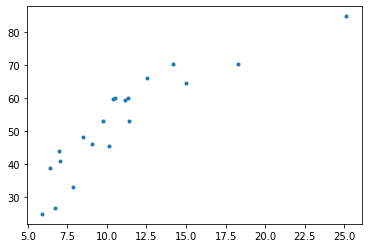

In [7]:
plt.plot(sr['rating'],sr['Points (mean)'],'.')

Chelsea
Leicester City
Liverpool
Manchester City
Manchester United


Text(0.5, 0, 'def')

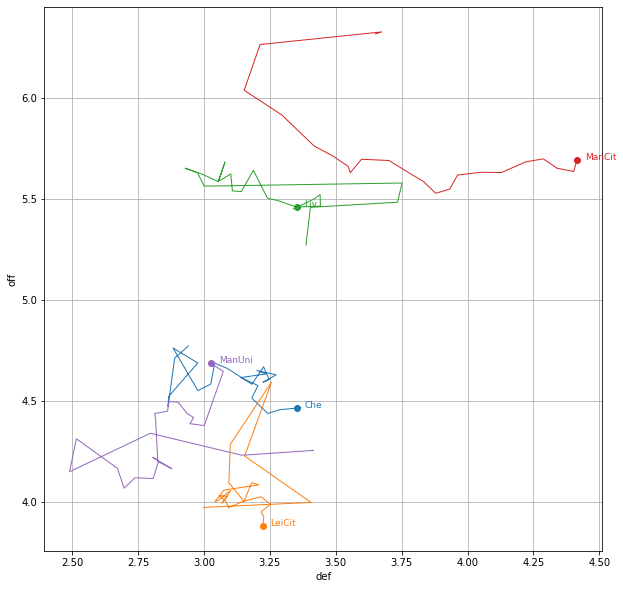

In [8]:
team_names = list(season.teams.keys())
y=[season.teams[x].offense for x in team_names]
x=[1/season.teams[x].defense for x in team_names]
plt.figure(figsize=(10,10))
#plt.plot(x,y,'.')
c=0
for x_,y_,name in zip(x,y,team_names):
    team = season.teams[name]
    if dict(sr['CL'])[name]>20:
        print(name)
        if c<=9:
            sym='-'
        else:
            sym='-'
        p=plt.plot(1/np.array(team.defense_hist),team.offense_hist,sym,label=name,color='C{:d}'.format(c),linewidth=1)
        c+=1
        plt.plot(x_,y_,'o',color=p[0].get_color())
        name_=''.join([x[:3] for x in name.split()])
        plt.text(x_+0.03,y_,name_,fontsize=9,color=p[0].get_color())
plt.grid(True)
plt.ylabel('off')
plt.xlabel('def')
#plt.legend()

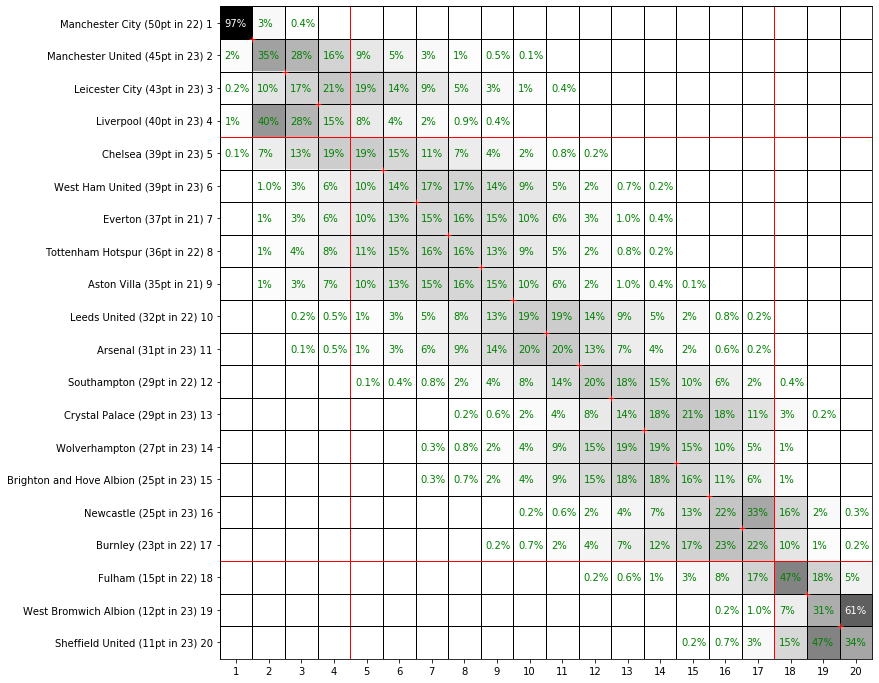

In [9]:
season.probability_grid(ind=ind);

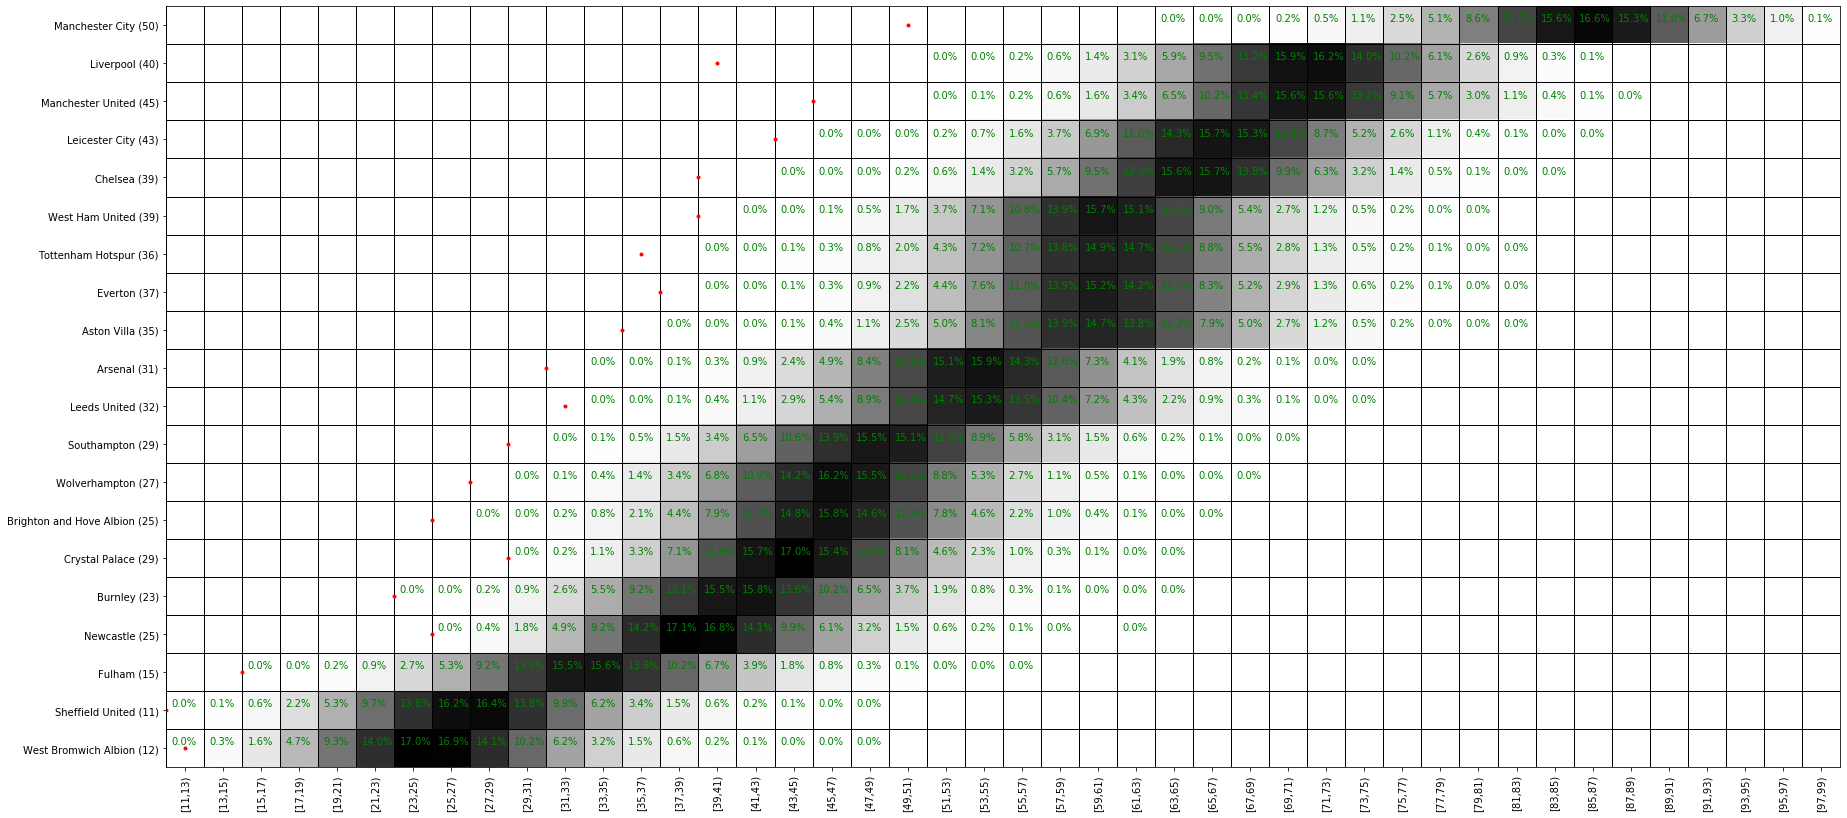

In [10]:
season.points_probability_grid(ind=ind);

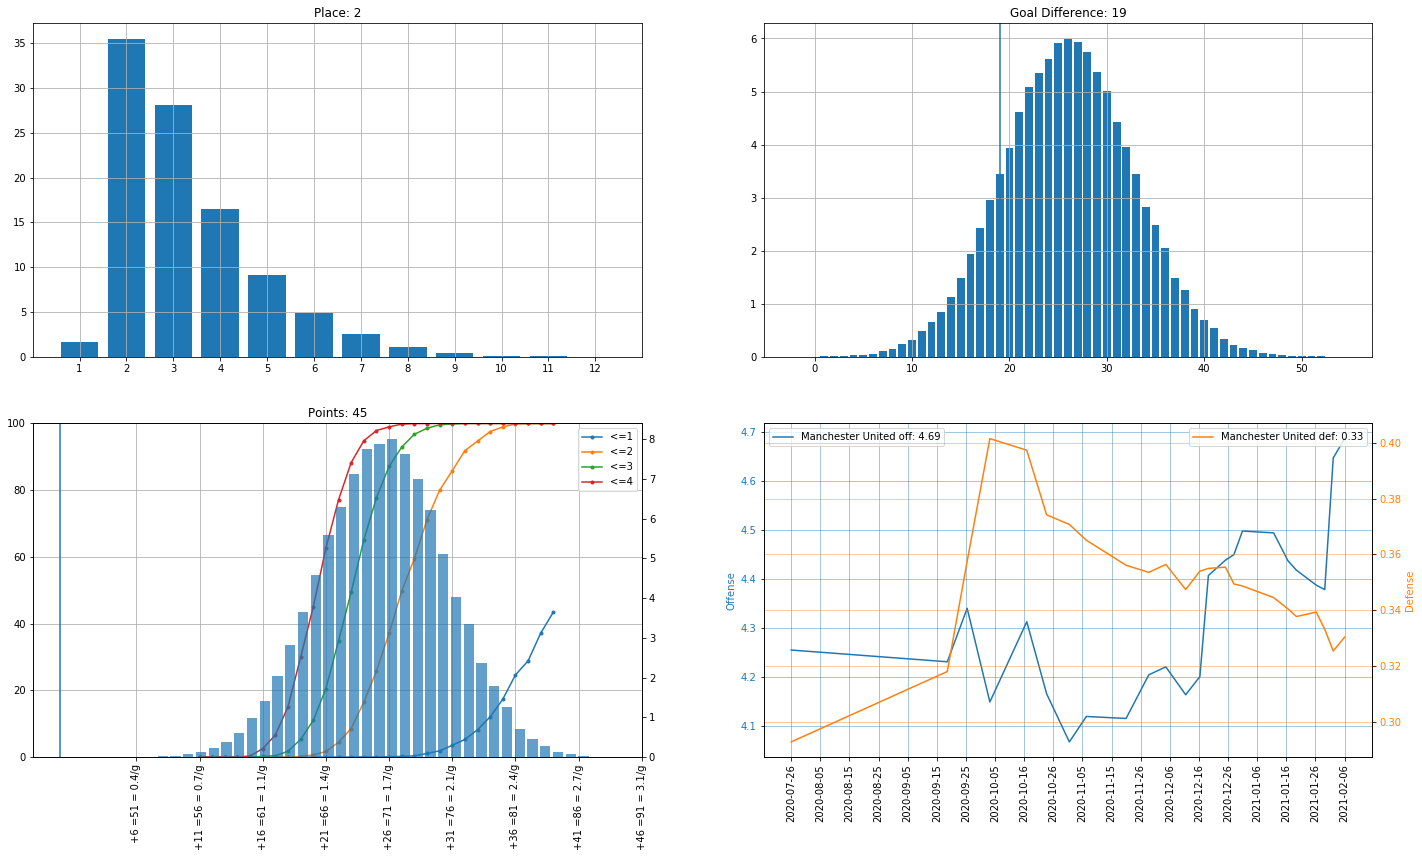

In [11]:
my_team = season.teams['Manchester United']

"""
names = []
importance = []
home=[]
away=[]

for m in season.matches_to_sim:
    #p=season.importance(m,ref_team=my_team,place=4,or_better=True)
    names.append(m.id)
    #importance.append(np.sum((p[1:]-p[0])**2))
    importance.append(season.importance(m,ref_team=my_team,place=4,or_better=True))
    home.append(m.home_team_name)
    away.append(m.away_team_name)

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]

"""
season.team_report(my_team,places=[1,2,3,4])


(array([81.763     , 70.39988409, 85.38253354, 76.50257584]),
 <Figure size 1152x648 with 1 Axes>)

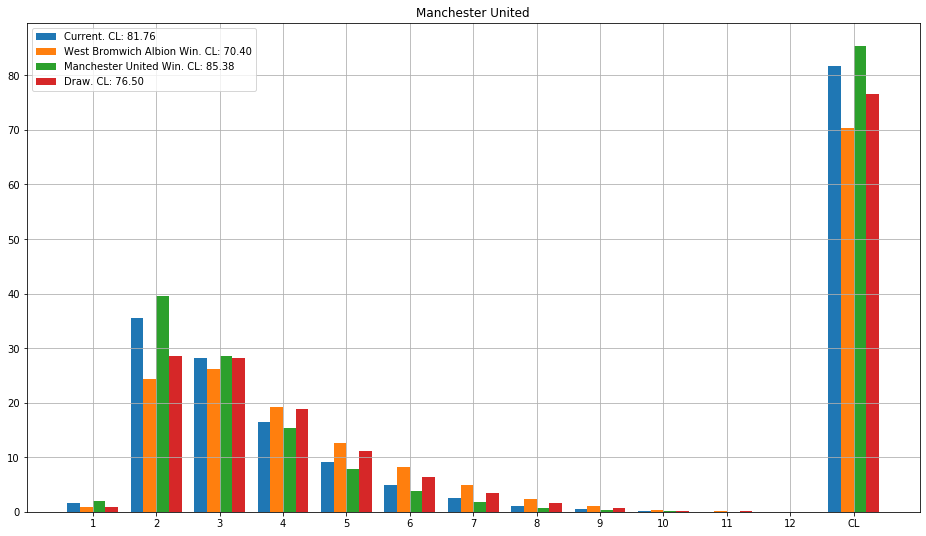

In [12]:
i=season.match_id['bpl_westbromwichalbion_manchesterunited_2021-02-14']
match = season.matches_to_sim[i]
mufc = season.teams['Manchester United']
#wh = season.teams['West Ham United']
season.what_if(match,ref_team=mufc,place=4,or_better=True)

D:\Miniconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


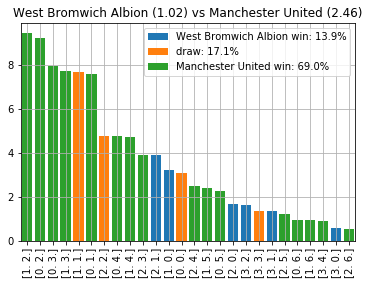

In [13]:
match.home_team.outcomes_vs(match.away_team)

In [14]:
home_team=match.home_team
away_team=match.away_team
if home_team.name == 'Manchester United':
    print('home')
    l_mu=home_team.offense*away_team.defense/90
    l_other=home_team.defense*away_team.offense/90
    other_team_name = away_team.name
elif away_team.name == 'Manchester United':
    print('away')
    l_mu=home_team.defense*away_team.offense/90
    l_other=home_team.offense*away_team.defense/90
    other_team_name = home_team.name
else:
    print('no MU')


g_mu=np.random.exponential(1/l_mu,[100000,100])
g_other=np.random.exponential(1/l_other,[100000,100])
ng_mu=(g_mu.cumsum(axis=1)<90).sum(axis=1)
ng_other=(g_other.cumsum(axis=1)<90).sum(axis=1)



u_res,n=np.unique(np.array([ng_mu,ng_other]),axis=1,return_counts=True)
#isort=np.argsort(-n)
#u_res[:,isort[:10]]
points_for_right_result = 2
points_for_right_score = 3

points=[]

for i in range(u_res.shape[1]):
    guess = u_res[:,i]
    ind_right_score = (ng_mu==guess[0])&((ng_other==guess[1]))
    points_=points_for_right_score*ind_right_score.mean()
    #points_=0
    ind_right_result = (guess[0]>guess[1])&(ng_mu>ng_other)
    ind_right_result = ind_right_result | (guess[0]==guess[1])&(ng_mu==ng_other)
    ind_right_result = ind_right_result | (guess[0]<guess[1])&(ng_mu<ng_other)
    points_+=points_for_right_result*ind_right_result.mean()
    points.append(points_)
    #g_mu[:,0]
    
points=np.array(points)


df=pd.DataFrame({'Manchester United':u_res[0,:],other_team_name:u_res[1,:],'Points':points})
df=df.sort_values(by='Points',ascending=False)
df.head(10)

away


,Manchester United,West Bromwich Albion,Points
15,2,0,1.65984
16,2,1,1.65933
24,3,1,1.61580
23,3,0,1.61007
7,1,0,1.60935
32,4,1,1.52160
31,4,0,1.52148
25,3,2,1.49877
33,4,2,1.45323
39,5,0,1.45011


In [15]:
season.matches_remaining(team_filter=['Manchester U'])

,Date,Home,Away,Home Wins,Draw,Away Wins,av HG,av AG
0,2021-02-14,West Bromwich Albion,Manchester United,13.8,17.5,68.7,1.0,2.5
1,2021-02-21,Manchester United,Newcastle,62.7,20.8,16.4,2.0,0.9
2,2021-02-28,Chelsea,Manchester United,39.3,25.0,35.7,1.5,1.4
3,2021-03-06,Manchester City,Manchester United,56.7,22.3,21.0,1.9,1.1
4,2021-03-13,Manchester United,West Ham United,47.4,24.2,28.4,1.7,1.3
5,2021-03-20,Crystal Palace,Manchester United,17.8,21.8,60.3,0.9,1.9
6,2021-04-03,Manchester United,Brighton and Hove Albion,48.2,24.3,27.5,1.6,1.2
7,2021-04-10,Tottenham Hotspur,Manchester United,30.6,23.8,45.7,1.3,1.7
8,2021-04-17,Manchester United,Burnley,58.1,23.5,18.4,1.8,0.9
9,2021-04-24,Leeds United,Manchester United,26.3,20.3,53.4,1.5,2.2


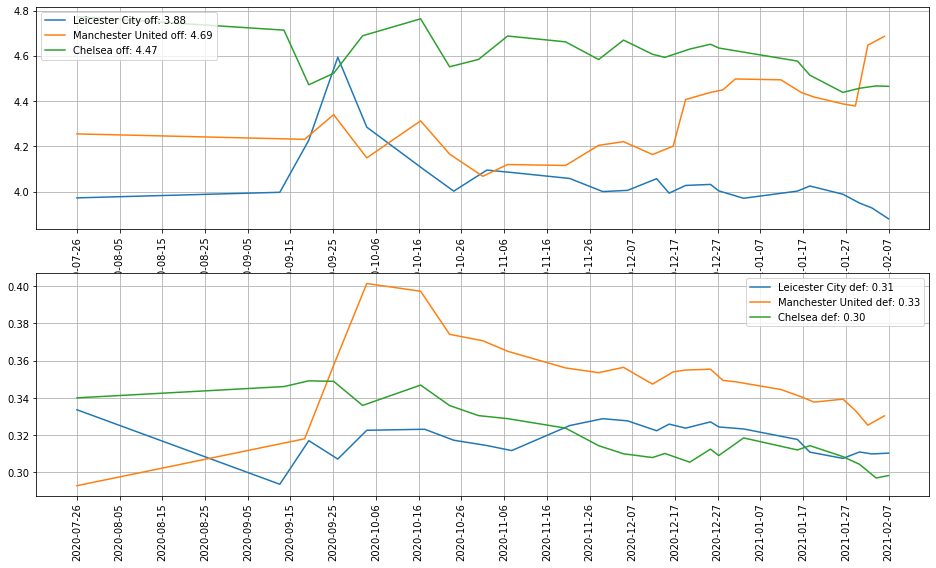

In [16]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


In [17]:
df=pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv')
df=df.set_index('name')
df = df.join(sr).reset_index()[['name','off','def','Off','Deff']].dropna()
df.head(10)

,name,off,def,Off,Deff
0,Manchester City,2.92,0.20,5.69,0.23
3,Liverpool,2.63,0.39,5.46,0.30
4,Chelsea,2.34,0.36,4.47,0.30
6,Manchester United,2.60,0.50,4.69,0.33
17,Arsenal,2.11,0.51,3.66,0.32
19,Leicester City,2.09,0.53,3.88,0.31
25,Tottenham Hotspur,2.13,0.65,4.07,0.36
31,Aston Villa,2.13,0.72,4.16,0.37
33,West Ham United,2.04,0.67,3.79,0.36
34,Brighton and Hove Albion,1.95,0.63,3.57,0.35


array([ 2.26405029, -0.81872993])

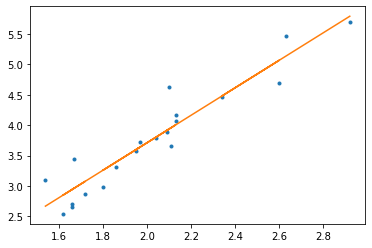

In [18]:
plt.plot(df['off'],df['Off'],'.')
poly = np.polyfit(df['off'],df['Off'],1)
plt.plot(df['off'],np.polyval(poly,df['off']))
poly

array([0.26344844, 0.18551092])

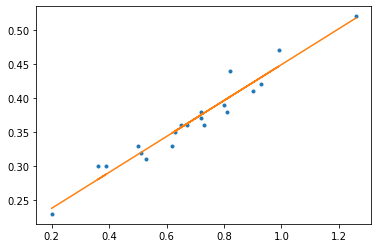

In [19]:
plt.plot(df['def'],df['Deff'],'.')
poly = np.polyfit(df['def'],df['Deff'],1)
plt.plot(df['def'],np.polyval(poly,df['def']))
poly

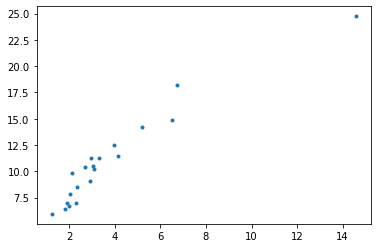

In [20]:
plt.plot(df['off']/df['def'],df['Off']/df['Deff'],'.')